In [27]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 31.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import numpy as np
import matplotlib ;  import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima 
import warnings 
warnings.filterwarnings("ignore")

### 실습 1

#### Step 1. 데이터 구성하기 

In [2]:
df = pd.read_csv('/home/piai/PABA_27/BigData/lecture/01 실습파일/2. Big Data 분석/IRIS.csv')
df.head()

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,SPECIES
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEPAL_LENGTH  150 non-null    float64
 1   SEPAL_WIDTH   150 non-null    float64
 2   PETAL_LENGTH  150 non-null    float64
 3   PETAL_WIDTH   150 non-null    float64
 4   SPECIES       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [4]:
df.describe()

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
# 데이터 분리 
df_x = df.drop('SPECIES', axis=1)
df_y = df['SPECIES']

In [7]:
df_x.head()

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [8]:
df_y.head()

0    setosa
1    setosa
2    setosa
3    setosa
4    setosa
Name: SPECIES, dtype: object

#### Step 2. 선형관계 확인: 산점도 행렬, 상관계수 

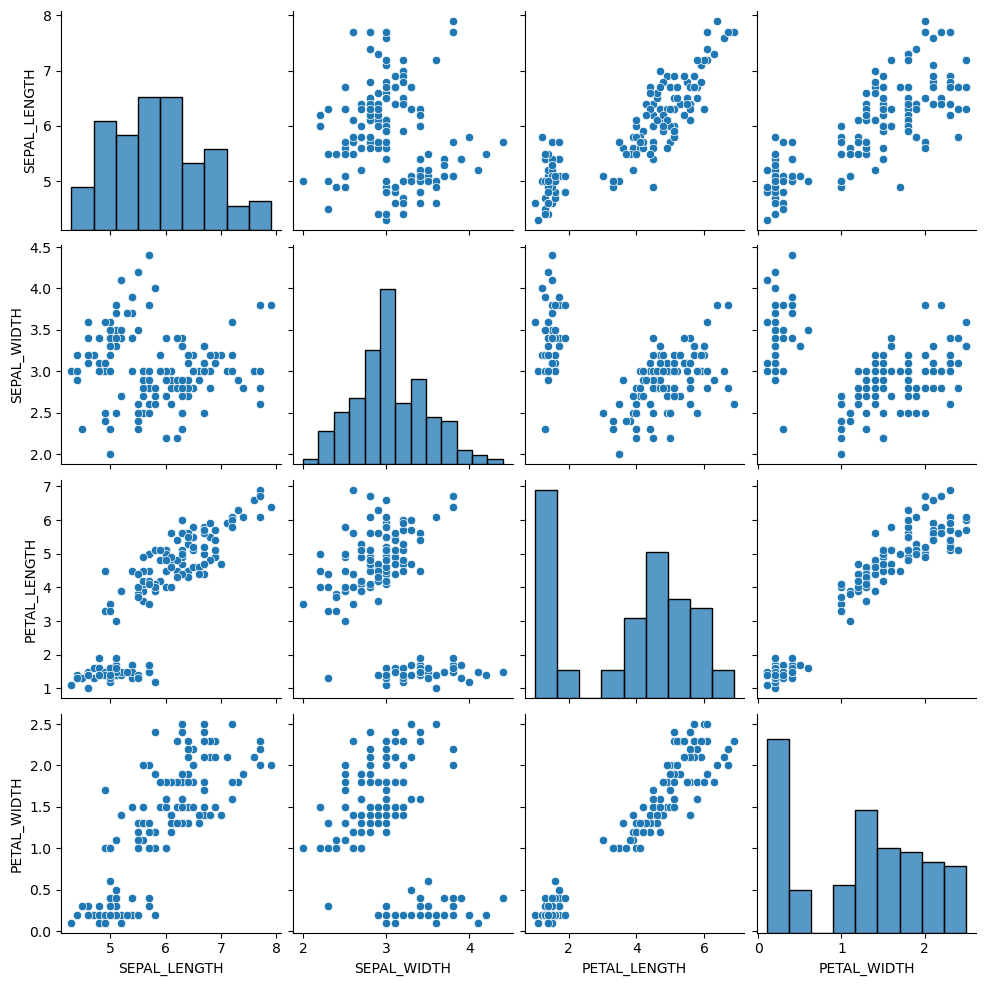

In [9]:
# 산점도 행렬 
sns.pairplot(df)

In [10]:
# Pearson 상관계수: pearson, kendall, spearman 
df_x.corr(method='pearson').round(3)

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
SEPAL_LENGTH,1.000,-0.118,0.872,0.818
SEPAL_WIDTH,-0.118,1.000,-0.428,-0.366
PETAL_LENGTH,0.872,-0.428,1.000,0.963
PETAL_WIDTH,0.818,-0.366,0.963,1.000


#### Step 3. 데이터 확인 및 Scaling

In [11]:
# 변수 이름 저장 
x_cols = df_x.columns
# Scale 변환
scaler = StandardScaler()
nd_scaled = scaler.fit_transform(df_x)
# 변환된 데이터 및 형태 확인 
print("Scaled Data:\n{}".format(nd_scaled[:5].round(3)))
print("Shape:\n{}".format(nd_scaled.shape))

Scaled Data:
[[-0.901  1.019 -1.34  -1.315]
 [-1.143 -0.132 -1.34  -1.315]
 [-1.385  0.328 -1.397 -1.315]
 [-1.507  0.098 -1.283 -1.315]
 [-1.022  1.249 -1.34  -1.315]]
Shape:
(150, 4)


In [12]:
# DataFrame으로 저장 
df_scaled = pd.DataFrame(nd_scaled, columns=x_cols)
df_scaled.head().round(3)

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
0,-0.901,1.019,-1.340,-1.315
1,-1.143,-0.132,-1.340,-1.315
2,-1.385,0.328,-1.397,-1.315
3,-1.507,0.098,-1.283,-1.315
4,-1.022,1.249,-1.340,-1.315


In [13]:
# Scale 변환 데이터 요약 통계량
df_scaled.describe().round(3)

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH
count,150.000,150.000,150.000,150.000
mean,-0.000,-0.000,-0.000,-0.000
std,1.003,1.003,1.003,1.003
min,-1.870,-2.434,-1.568,-1.447
25%,-0.901,-0.592,-1.227,-1.184
50%,-0.053,-0.132,0.336,0.133
75%,0.675,0.559,0.763,0.791
max,2.492,3.091,1.786,1.712


#### Step 4. 주성분 분석 및 결과: 주성분 점수, 고유벡터, 기여율, 해석 등 

In [14]:
# 주성분 분석 
pca = PCA(n_components=4)
nd_pca = pca.fit_transform(df_scaled)
# 생성된 주성분 점수 확인 
print("PCA Data:\n{}".format(nd_pca[:5]))
# 생성된 주성분 점수 Row, Column 개수 확인
print("Shape:\n{}".format(nd_pca.shape))

PCA Data:
[[-2.26470281  0.4800266  -0.12770602 -0.0241682 ]
 [-2.08096115 -0.67413356 -0.23460885 -0.10300677]
 [-2.36422905 -0.34190802  0.04420148 -0.02837705]
 [-2.29938422 -0.59739451  0.09129011  0.06595556]
 [-2.38984217  0.64683538  0.0157382   0.03592281]]
Shape:
(150, 4)


In [15]:
# 주성분 점수 저장 및 확인 
df_pca = pd.DataFrame(nd_pca, columns=["Prin1", "Prin2", "Prin3", "Prin4"])
# 주성분 분석용 데이터와 주성분 점수 결합
df_scaled_pca = df_scaled.join(df_pca)
df_scaled_pca.head()

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,Prin1,Prin2,Prin3,Prin4
0,-0.900681,1.019004,-1.340227,-1.315444,-2.264703,0.480027,-0.127706,-0.024168
1,-1.143017,-0.131979,-1.340227,-1.315444,-2.080961,-0.674134,-0.234609,-0.103007
2,-1.385353,0.328414,-1.397064,-1.315444,-2.364229,-0.341908,0.044201,-0.028377
3,-1.506521,0.098217,-1.283389,-1.315444,-2.299384,-0.597395,0.091290,0.065956
4,-1.021849,1.249201,-1.340227,-1.315444,-2.389842,0.646835,0.015738,0.035923


In [16]:
# 주성분 분석 통계량 저장: 주성분 번호, Eigenvalue, Eigenvalue ratio
ds_pca = pd.DataFrame()
ds_pca["PrinNo"] = [i for i in range(1, 5)]
ds_pca["EigenValues"] = pca.explained_variance_
ds_pca["EigenValueRatio"] = pca.explained_variance_ratio_
ds_pca["CumEigenValueRatio"] = np.cumsum(pca.explained_variance_ratio_)
ds_pca.round(3)

,PrinNo,EigenValues,EigenValueRatio,CumEigenValueRatio
0,1,2.938,0.730,0.730
1,2,0.920,0.229,0.958
2,3,0.148,0.037,0.995
3,4,0.021,0.005,1.000


CumEigenValueRatio: 각 주성분이 데이터의 총 변동성을 얼마나 설명하는지를 누적해서 나타내는 비율
- 일반적으로 누적 설명 분산 비율이 70%~90% 이상일 때까지 주성분을 선택한다.
- 누적 설명 분산 비율이 높을수록 선택한 주성분들이 원래 데이터의 변동성을 더 잘 설명하게 된다. 

위의 표를 기준으로 90%의 변동성을 설명하는 주성분을 선택하려면: 
- 첫번째 주성분 (Prin1): 누적 설명 분산 비율 0.730 (73.0%)
- 두번째 주성분 (Prin2): 누적 설명 분산 비율 0.958 (95.8%)

In [17]:
# 주성분 분석 데이터의 변수 이름 
x_cols = pd.DataFrame({"Feature":df_x.columns})
# 주성분 Prin1~4까지의 고유벡터 저장
# 전치 결과 
df_eigenvector = pd.concat([x_cols, pd.DataFrame(pca.components_.T*-1,\
                                                 columns=["Prin1", "Prin2", "Prin3", "Prin4"])], axis=1)
df_eigenvector.round(3)

,Feature,Prin1,Prin2,Prin3,Prin4
0,SEPAL_LENGTH,-0.521,-0.377,0.720,0.261
1,SEPAL_WIDTH,0.269,-0.923,-0.244,-0.124
2,PETAL_LENGTH,-0.580,-0.024,-0.142,-0.801
3,PETAL_WIDTH,-0.565,-0.067,-0.634,0.524


- 고유값 확인 및 주성분 해석 
    - 1주성분은 SEPAL_WIDTH에서 양의 상관관계를 띤다. 
    - 2주성분은 SEDPAL_WIDTH에서 강한 음의 상관관계를 띤다. 

#### Step 5. 주성분 상관분석

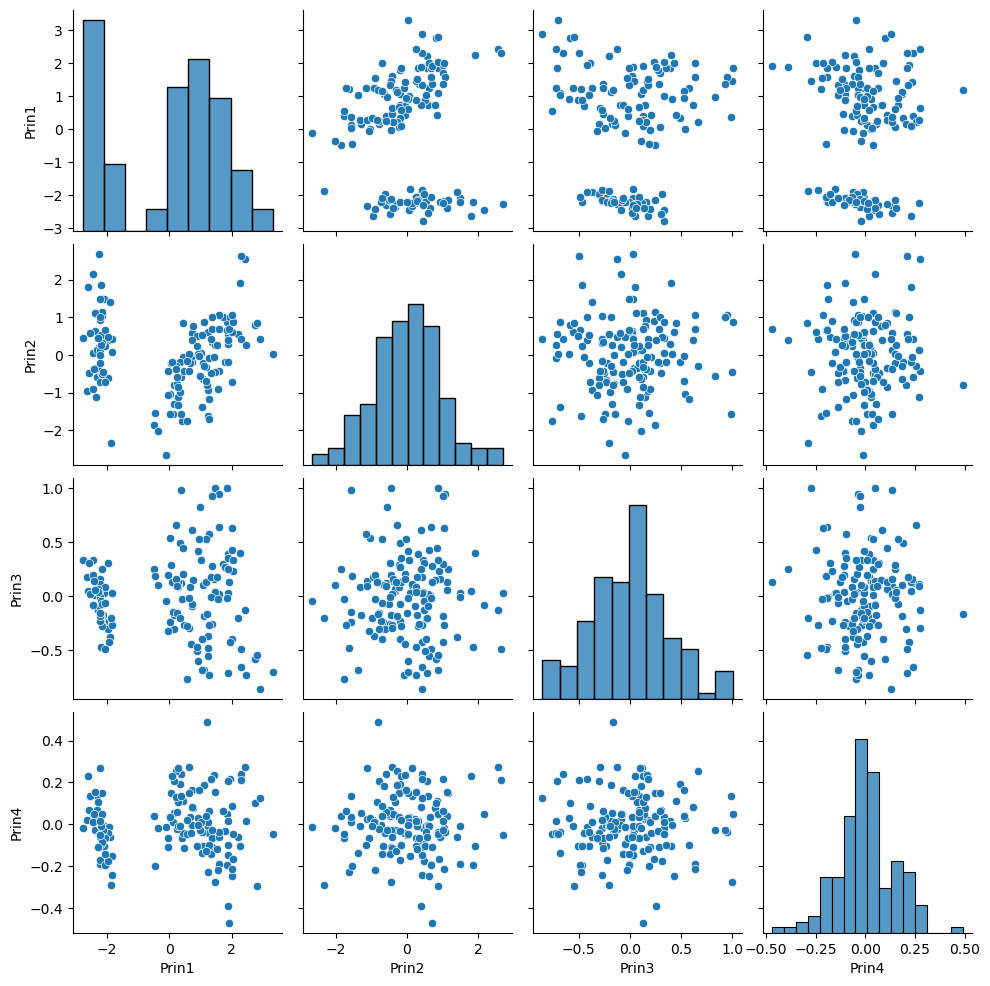

In [18]:
# 산점도 행렬 
sns.pairplot(df_pca)

In [19]:
# 상관계수 
df_pca.corr().round(3)

,Prin1,Prin2,Prin3,Prin4
Prin1,1.0,0.0,-0.0,-0.0
Prin2,0.0,1.0,0.0,-0.0
Prin3,-0.0,0.0,1.0,-0.0
Prin4,-0.0,-0.0,-0.0,1.0


- 주성분은 서로 독립적이다. (상관계수는 0이다.)

#### Step 6. 주성분 결과 탐색: 품종별 입력/주성분 변수 분포 (산점도 등)

In [25]:
df_pca['SPECIES'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: SPECIES, dtype: int64

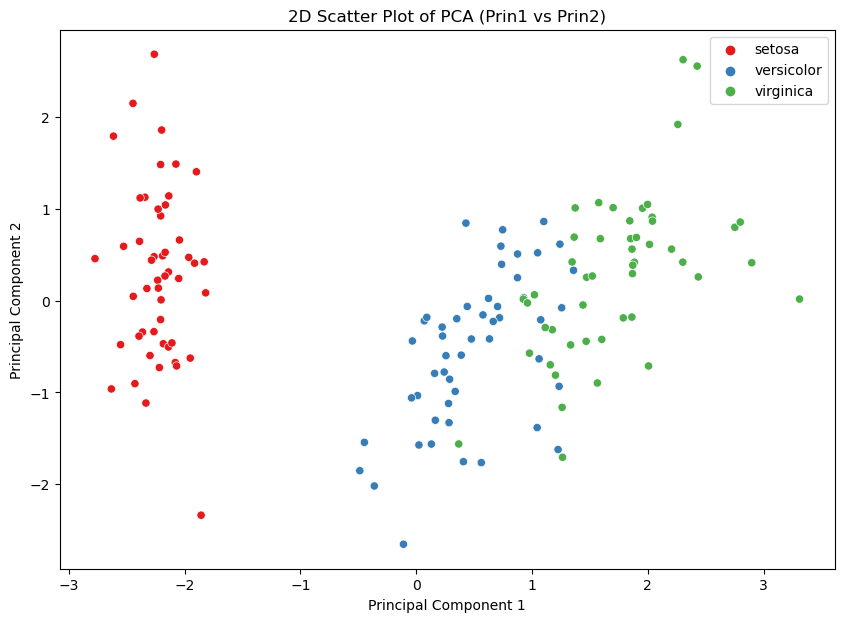

In [24]:
# 주성분 점수 저장 및 확인
df_pca = pd.DataFrame(nd_pca, columns=["Prin1", "Prin2", "Prin3", "Prin4"])
df_pca["SPECIES"] = df["SPECIES"].values  # 품종 정보를 포함

# 2D 산점도 (PC1 vs PC2)
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Prin1', y='Prin2', hue='SPECIES', data=df_pca, palette='Set1')
plt.title('2D Scatter Plot of PCA (Prin1 vs Prin2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='best')
plt.show()

- PCA는 전체 데이터셋을 사용하여 주성분을 계산한다. 
- 2D 산점도에서 각 품종별로 다른 색깔로 표시된 점들은 첫번째와 두번째 주성분의 점수에 따라 분포된다. 
- 품종 간의 분포 차이를 통해 주성분이 데이터의 변동성을 어떻게 설명하는지 확인할 수 있다. 
- 예를 들어, 서로 다른 품종이 주성분 공간에서 잘 분리된다면, PCA가 품종 간 차이를 잘 의미한다.

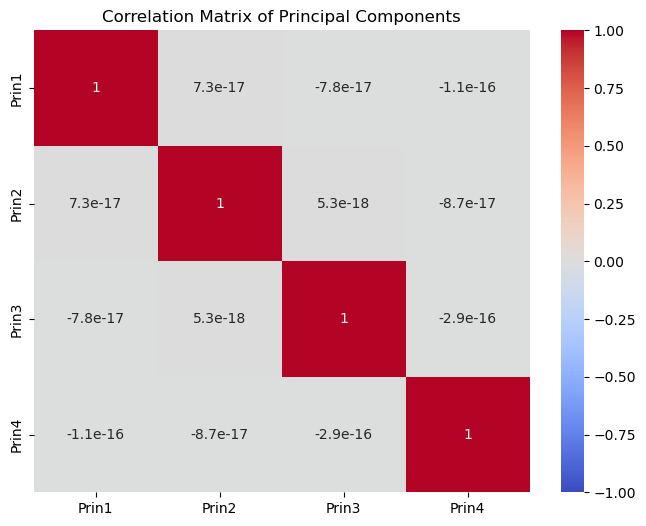

In [21]:
# 주성분 간의 상관계수 행렬 히트맵
plt.figure(figsize=(8, 6))
sns.heatmap(df_pca.iloc[:, :4].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Principal Components')
plt.show()

- 주성분 간의 상관관계를 확인하여 각 주성분이 서로 독립적인지 여부를 분석한다. 
- 주성분들이 서로 독립적일수록 (상관계수가 0에 가까울수록) PCA가 잘 수행되었다고 할 수 있다.
- 히트맵에서 각 주성분 간의 상관계수가 낮으면, 주성분들이 데이터의 다른 측면을 설명하고 있음을 알 수 있다.

### 실습 2

#### Step 1. 데이터 구성하기 

In [30]:
df = pd.read_csv('//home/piai/PABA_27/BigData/lecture/01 실습파일/2. Big Data 분석/df_USD.csv', parse_dates=["APPL_DATE"])
df.head()

,APPL_DATE,STD_RATE
0,2016-01-01,1178
1,2016-01-02,1178
2,2016-01-03,1178
3,2016-01-04,1184
4,2016-01-05,1185


#### Step 2. 변동 추세 확인 

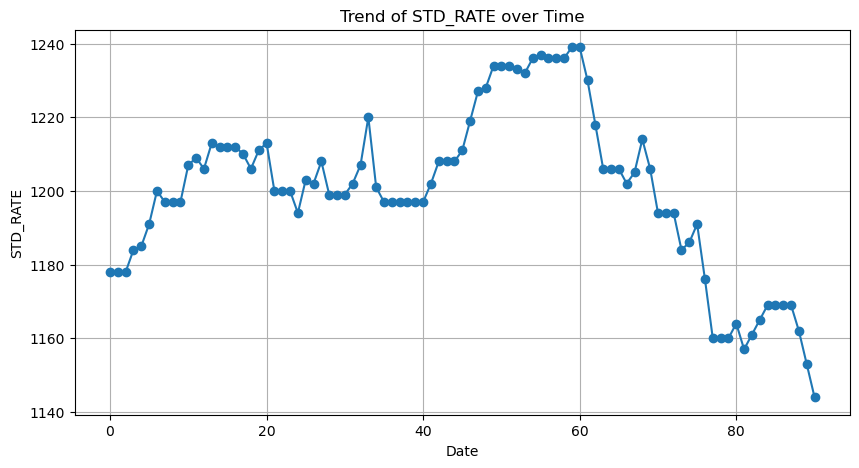

In [31]:
# 시계열 그래프 작성
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['STD_RATE'], marker='o')
plt.title('Trend of STD_RATE over Time')
plt.xlabel('Date')
plt.ylabel('STD_RATE')
plt.grid(True)
plt.show()

In [42]:
# Train/Test 데이터 분할: index 직접 지정 
train = df.loc[df['APPL_DATE'] <= '2016 -03-22']
test = df.loc[df['APPL_DATE'] > '2016-03-22']

print("Train Data: ", train.shape)
print("Test Data: ", test.shape)

Train Data:  (82, 2)
Test Data:  (9, 2)


In [43]:
train.head()

,APPL_DATE,STD_RATE
0,2016-01-01,1178
1,2016-01-02,1178
2,2016-01-03,1178
3,2016-01-04,1184
4,2016-01-05,1185


In [44]:
test.head()

,APPL_DATE,STD_RATE
82,2016-03-23,1161
83,2016-03-24,1165
84,2016-03-25,1169
85,2016-03-26,1169
86,2016-03-27,1169


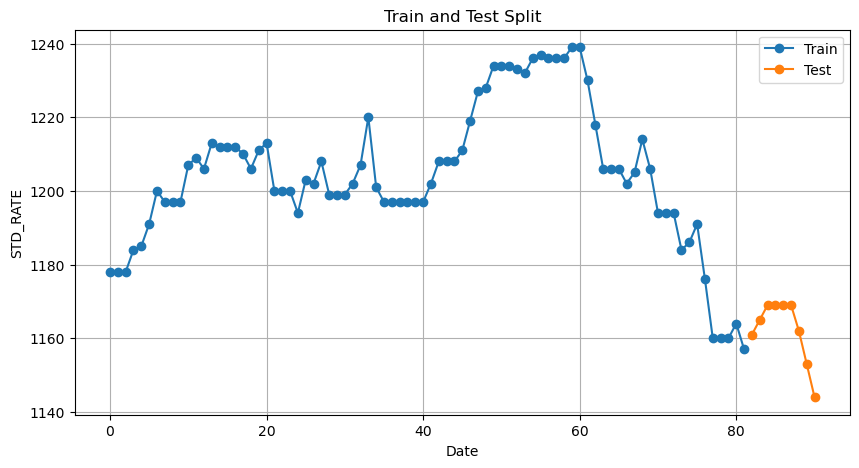

In [45]:
# Train/Test 데이터 시각화
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['STD_RATE'], label='Train', marker='o')
plt.plot(test.index, test['STD_RATE'], label='Test', marker='o')
plt.title('Train and Test Split')
plt.xlabel('Date')
plt.ylabel('STD_RATE')
plt.legend()
plt.grid(True)
plt.show()

#### Step 3. 시계열 분석 - 정상성 확인/자기상관성 확인 

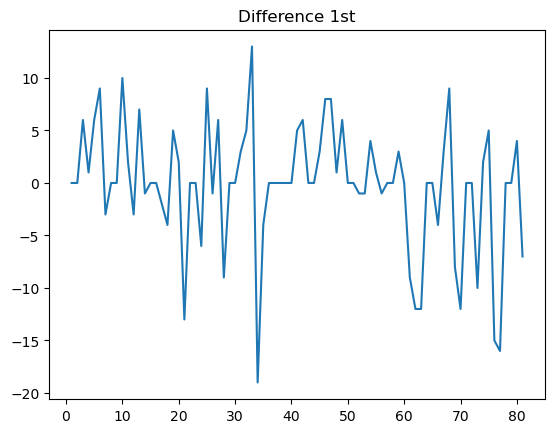

In [49]:
# 1차 차분
diff_1 = train['STD_RATE'].diff(periods=1).dropna()
diff_1.plot(title='Difference 1st')
plt.show()

- 데이터가 안정적인 수준을 중심으로 무작위로 분포한다면, 데이터는 정상성을 가진다고 볼 수 있다. 
- 시계열 데이터에 뚜렷한 추세가 있을 경우, 1차 차분을 통해 이를 제거할 수 있다. 

In [51]:
from statsmodels.tsa.stattools import adfuller

# 1차 차분에 대한 ADF 테스트
adf_result_1st = adfuller(diff_1, autolag='AIC')   
print('1차 차분 데이터에 대한 ADF 테스트 결과:')
print('ADF Statistic: %f' % adf_result_1st[0])
print('p-value: %f' % adf_result_1st[1])
for key, value in adf_result_1st[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

1차 차분 데이터에 대한 ADF 테스트 결과:
ADF Statistic: -7.827037
p-value: 0.000000
Critical Value (1%): -3.515
Critical Value (5%): -2.898
Critical Value (10%): -2.586


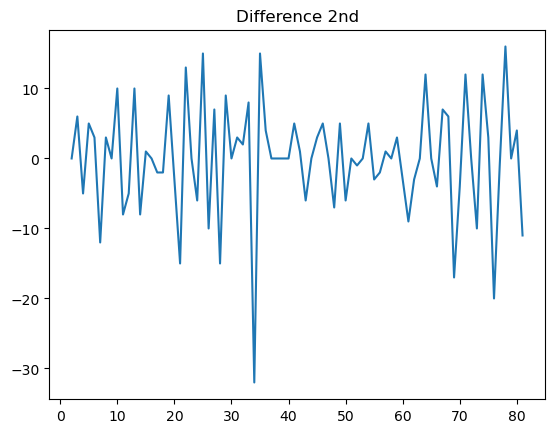

In [50]:
# 2차 차분 
diff_2 = diff_1.diff(periods=1).dropna()
diff_2.plot(title='Difference 2nd')
plt.show()

- 2차 차분은 1차 차분으로도 정상성을 확보할 수 없는 경우 추가적으로 적용한다. 
- 2차 차분 그래프에서 데이터가 일정한 수준으로 변동하고 있다면, 이는 정상성을 확보했음을 의미한다.

In [52]:
# 2차 차분에 대한 ADF 테스트
adf_result_2nd = adfuller(diff_2, autolag='AIC')
print('\n2차 차분 데이터에 대한 ADF 테스트 결과:')
print('ADF Statistic: %f' % adf_result_2nd[0])
print('p-value: %f' % adf_result_2nd[1])
for key, value in adf_result_2nd[4].items():
    print('Critical Value (%s): %.3f' % (key, value))


2차 차분 데이터에 대한 ADF 테스트 결과:
ADF Statistic: -6.075048
p-value: 0.000000
Critical Value (1%): -3.523
Critical Value (5%): -2.902
Critical Value (10%): -2.588


In [53]:
# p-value가 0.05 이하이면 데이터가 정상성(Stationarity)을 가짐
if adf_result_1st[1] <= 0.05:
    print("\n1차 차분 데이터는 정상성 데이터입니다.")
else:
    print("\n1차 차분 데이터는 정상성이 없습니다.")

if adf_result_2nd[1] <= 0.05:
    print("2차 차분 데이터는 정상성 데이터입니다.")
else:
    print("2차 차분 데이터는 정상성이 없습니다.")


1차 차분 데이터는 정상성 데이터입니다.
2차 차분 데이터는 정상성 데이터입니다.


- ADF 통계량과 p-value를 통해 데이터의 정상성을 확인한다. 
- p-value가 0.05 이하이면 데이터가 정상성을 가졌다고 판단한다.
- 1,2차 차분 데이터 모두 정상성 데이터이다.

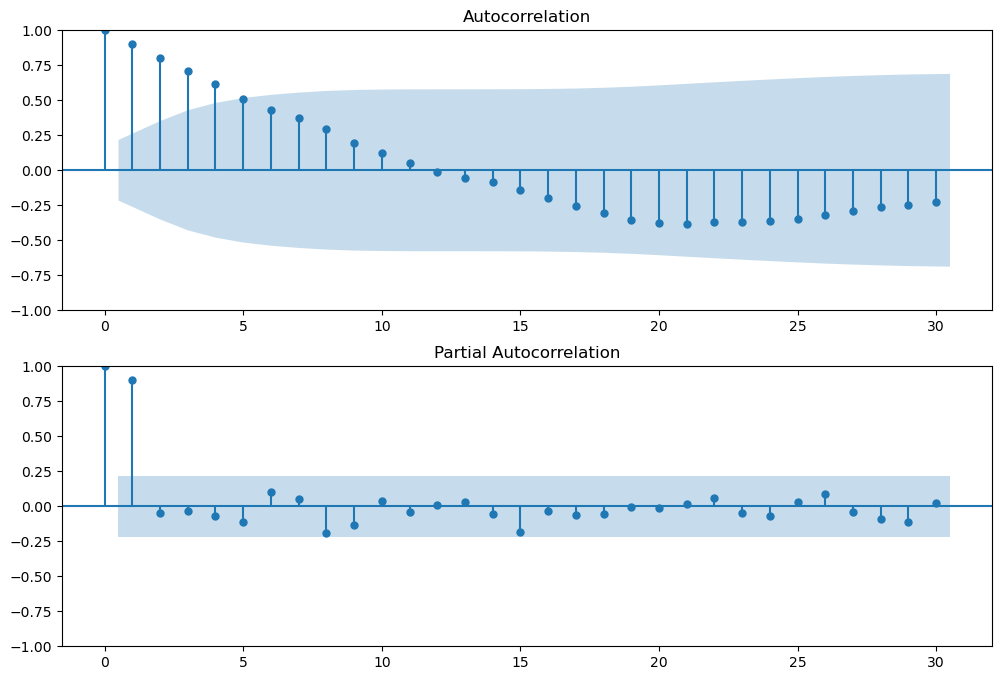

In [54]:
# 자기회귀 최대 p기간 지정 
lag_size = 30
fig = plt.figure(figsize=(12, 8))
# acf 그래프를 그릴 공간 생성 
ax1 = fig.add_subplot(211)
# 자기상관 함수 그래프 plot_acf 함수 사용
fig = plot_acf(train['STD_RATE'], lags=lag_size, ax=ax1)
# pacf 그래프를 그릴 공간 생성
ax2 = fig.add_subplot(212)
# 부분 자기상관 함수 그래프 plot_pacf 함수 사용
fig = plot_pacf(train['STD_RATE'], lags=lag_size, ax=ax2)

- ACF는 지속적으로 감소하고 p=12 시점에서 양에서 음으로 변하고, PACF는 p=1 시점에서 0.9보다 크고 이후 급격히 감소(절단면)한다. 
- p=1, q=0 모델이 적당하다고 판단한다.=> ARMA(1,0)

In [56]:
# 시계열 분석 
# Train 데이터 이용, AR(1), 차분(2), MA(0)인 ARIMA 모델
ts_model = ARIMA(train['STD_RATE'], order=(1, 2, 0))

# 데이터 적합
ts_result = ts_model.fit()
print(ts_result.summary())

                               SARIMAX Results                                
Dep. Variable:               STD_RATE   No. Observations:                   82
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -274.804
Date:                Wed, 07 Aug 2024   AIC                            553.608
Time:                        18:49:06   BIC                            558.372
Sample:                             0   HQIC                           555.518
                                 - 82                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3764      0.124     -3.047      0.002      -0.618      -0.134
sigma2        56.2767      7.107      7.919      0.000      42.348      70.206
Ljung-Box (L1) (Q):                   2.21   Jarque-

- 로그 가능도, AIC, BIC, HQIC값을 통해 모델의 적합도를 평가할 수 있다. AIC, BIC, HQIC 값이 낮을수록 모델의 적합도가 높다.
- AR 계수는 유의미하며, 음수 값을 가지므로 이전 시점의 값이 현재 시점의 값에 부정적인 영향을 미친다고 해석할 수 있다. 

- Ljung-Box 테스트의 p-value가 0.05보다 크므로 잔차가 무작위성을 띤다고 볼 수 있다.
- Jarque-Bera 테스트의 p-value가 0.00이므로 잔차가 정규 분포를 따르지 않는다는 것을 의미한다.
- Heteroskedasticity 테스트의 p-value가 0.27로 잔차의 이분산성이 없다고 해석할 수 있다.
- 잔차의 왜도는 -0.92로, 잔차가 음수 방향으로 치우쳐져 있다. 
- 잔차의 첨도는 4.79로, 정규 분포보다 뾰족한 분포를 보인다. 

#### Step 4. 예측 및 결과 해석

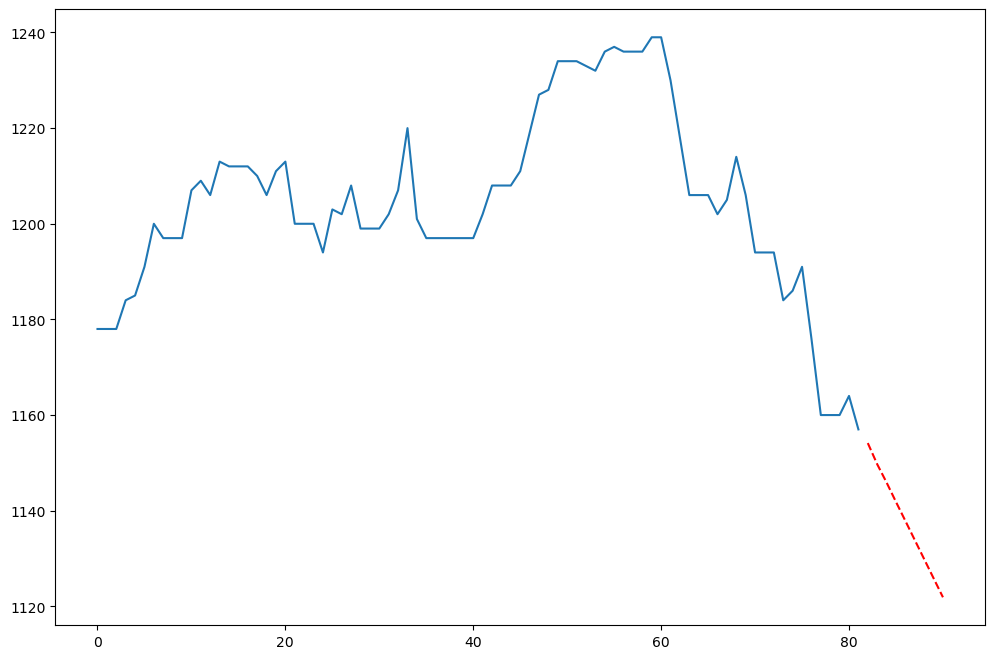

In [59]:
# 예측 시작/종료 날짜 지정 
start_time = test.index.min()
end_time = test.index.max()
fig, ax = plt.subplots(figsize=(12, 8))
# 예측 전까지 데이터
ax = train['STD_RATE'].plot(ax=ax)
# 예측 그래프 생성 함수
fig = ts_result.predict(start=start_time, end=end_time, ax=ax, plot_insample=False).plot(ax=ax, style='r--', label='Forecast')

- 2016년 3월 23~31일까지의 예측값
- 지속적으로 감소할 것으로 예측된다. 

In [73]:
# 전체 기간의 실제값, 예측값 비교 
start_time = df.index[2]
y_pred = ts_result.predict(start=start_time, end=end_time, typ='levels')
df_merge = df
df_merge['예측값'] = y_pred
df_merge.head()

,APPL_DATE,STD_RATE,예측값
0,2016-01-01,1178,NaN
1,2016-01-02,1178,NaN
2,2016-01-03,1178,1178.029066
3,2016-01-04,1184,1178.000000
4,2016-01-05,1185,1187.741796


<Axes: title={'center': 'STD_RATE and Forecast'}>

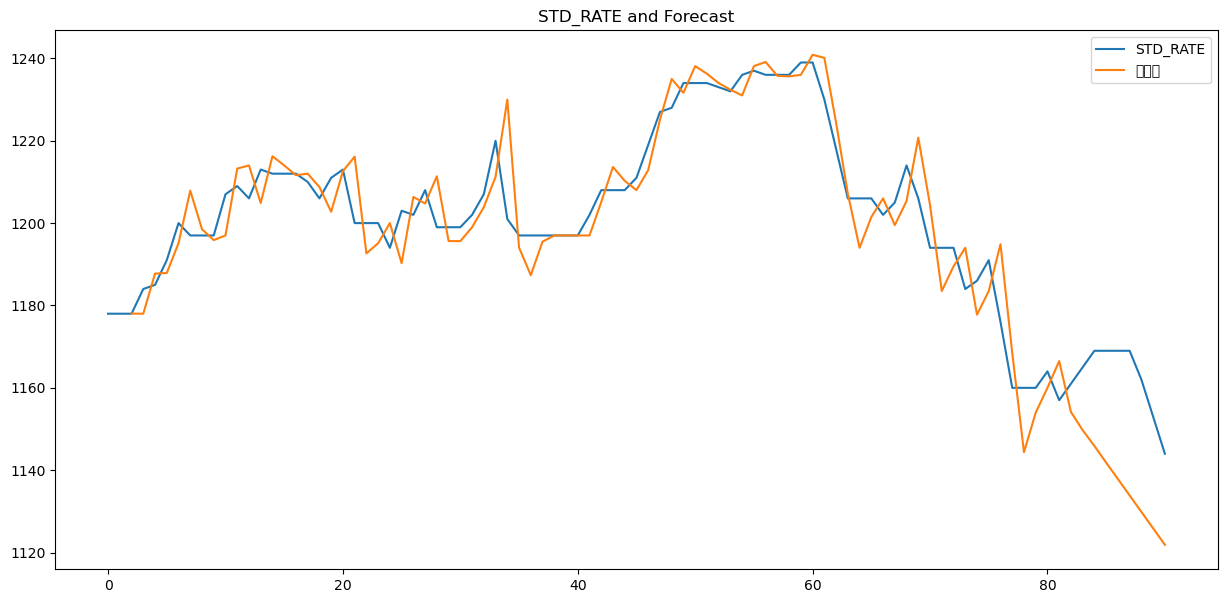

In [74]:
# 추세 그래프 생성 및 확인 
df_merge[['STD_RATE', '예측값']].plot(title='STD_RATE and Forecast', figsize=(15, 7))

- 모델 학습구간은 실제값 대비 지연(lag) 현상이 확인되며 예측 구간은 오차가 크다. 